In [1]:
## installing cmdstan
# install.packages("cmdstanr", repos = c("https://mc-stan.org/r-packages/", getOption("repos")))

## installing stan. There are other options that could be included for openmpi and GPU computation.
# library(cmdstanr)
# cpp_options <- list(
#                      "CXX" = "g++",
#                      "CXXFLAGS+= -march=native"
#                    )

# install_cmdstan(cpp_options = cpp_options, overwrite = TRUE )

# Exercise 1)

## a)

In [2]:
library(aaltobda)
library(cmdstanr)
data("bioassay")

This is cmdstanr version 0.5.3

- CmdStanR documentation and vignettes: mc-stan.org/cmdstanr

- CmdStan path: /home/jmaronasm/.cmdstan/cmdstan-2.30.1

- CmdStan version: 2.30.1



In [3]:
cmdstan_path()
cmdstan_version()

[1] "/home/jmaronasm/.cmdstan/cmdstan-2.30.1"

[1] "2.30.1"

In [4]:
## Set path to model
file   <- file.path("stan_files", "bioassay.stan")
model  <- cmdstan_model(file)

model$print()

//  Author: * Juan Maroñas Molano *
//  This file implements the bioassay problem from Bayesian Data Analysis book. This a generalized linear model with a Gaussian prior over the linear parameters
//  and a binomial likelihood for the data, with parameter theta = inv_logit( alpha + beta * x) and y ~ Binomial( n, theta ), where n,y,x are data.
//  The parameters from the prior can be feed as arguments to the model. This could also be hardcoded in the transformed data module.

// Input data to Stan. Can be data, hyperprior parameters etc.
data {
      // Prior distribution
      vector[2]   prior_mean; // the vector where the prior mean is specified.
      matrix[2,2] prior_cov ; // the prior covariance. We don't check its possitive semidefinite and let stan do that for us.

      // Data information
      int <lower = 1> N;                     // Number of observations.
      array[N] int <lower = 1> n;            // Number of trials
      array[N] int <lower = 0, upper = n> y; // Numbe

In [5]:
## MCMC sampling

# prior parameters
prior_mean <- c(0,10)
cov_xy     <- 0.6 * 10 * 2

prior_cov  <- array(c( 2**2, cov_xy , cov_xy, 10**2 ), dim = c(2,2) )

# Data specified in the data module
data_list <- list(
                    x = bioassay$x, 
                    y = bioassay$y,
                    n = bioassay$n,
                    N = length(bioassay$x),
                    # Prior parameters
                    prior_mean = prior_mean,
                    prior_cov  = prior_cov
                  )

fit <- model$sample(
                      data            = data_list, 
                      seed            = 123, 
                      chains          = 4, 
                      parallel_chains = 4,
                      refresh         = 500 # print update every 500 iters
                   )

Running MCMC with 4 parallel chains...

Chain 1 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 1 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 1 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 1 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 1 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 2 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 2 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 2 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 2 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 2 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 3 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 3 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 3 Iteration: 1000 / 2000 [ 50%]  (Warmup) 
Chain 3 Iteration: 1001 / 2000 [ 50%]  (Sampling) 
Chain 3 Iteration: 1500 / 2000 [ 75%]  (Sampling) 
Chain 3 Iteration: 2000 / 2000 [100%]  (Sampling) 
Chain 4 Iteration:    1 / 2000 [  0%]  (Warmup) 
Chain 4 Iteration:  500 / 2000 [ 25%]  (Warmup) 
Chain 4 Itera

## c)    

I have used the machinery from stan, which I think it samples from a uniform between $[-2,2]$. Attending to (Gelman and Rubin, 1992) we should fit an overdispersed multimodal approximation to the posterior and then sample from it. However if Stan does not has that as default (or an input option to do it), I guess it is something that in practice does not make a lot of difference. Actually I obtain similar Rhat and posterior than when using random MCMC in assignment 5 with overdispersed input points.

In [6]:
## sumary
fit$summary()

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-7.1709683,-6.8575000,1.0508000,0.7887210,-9.1657845,-6.1717330,1.000660,1325.424,1615.700
alpha_beta[1],0.9945960,0.9552095,0.9222588,0.9081896,-0.4743281,2.5801000,1.001201,1114.859,1260.546
alpha_beta[2],10.7441560,10.1570500,4.6944619,4.7297016,4.2852760,19.3464050,1.002436,1068.530,1388.525
theta[1],-8.2453778,-7.7928450,3.5421193,3.4564224,-14.7554500,-3.2848255,1.002084,1300.458,1732.693
theta[2],-2.2286507,-2.1271500,1.1082418,1.0578796,-4.2557835,-0.6085568,1.000870,2638.062,2501.178
theta[3],0.4573882,0.4350320,0.7987656,0.7810515,-0.8207328,1.8171025,1.000683,1369.594,1765.133
theta[4],8.8378299,8.3675650,4.0622643,4.1399900,3.0163800,16.0967500,1.002491,980.797,1290.259


## d)

I have used Stan's default which uses 1000 samples for adaptation and other 1000 draws from the posterior. 

## e)

Warm up length is 1000.

## f)

I have used 4 chains, which is the recommended value in BDA and default in Stan. 

## g)

In [7]:
## extract draws
draws <- fit$draws(format = 'draws_list')

In [8]:
alpha_ch1 <- draws[['1']][['alpha_beta[1]']]
alpha_ch2 <- draws[['2']][['alpha_beta[1]']]
alpha_ch3 <- draws[['3']][['alpha_beta[1]']]
alpha_ch4 <- draws[['4']][['alpha_beta[1]']]

In [9]:
beta_ch1 <- draws[['1']][['alpha_beta[2]']]
beta_ch2 <- draws[['2']][['alpha_beta[2]']]
beta_ch3 <- draws[['3']][['alpha_beta[2]']]
beta_ch4 <- draws[['4']][['alpha_beta[2]']]

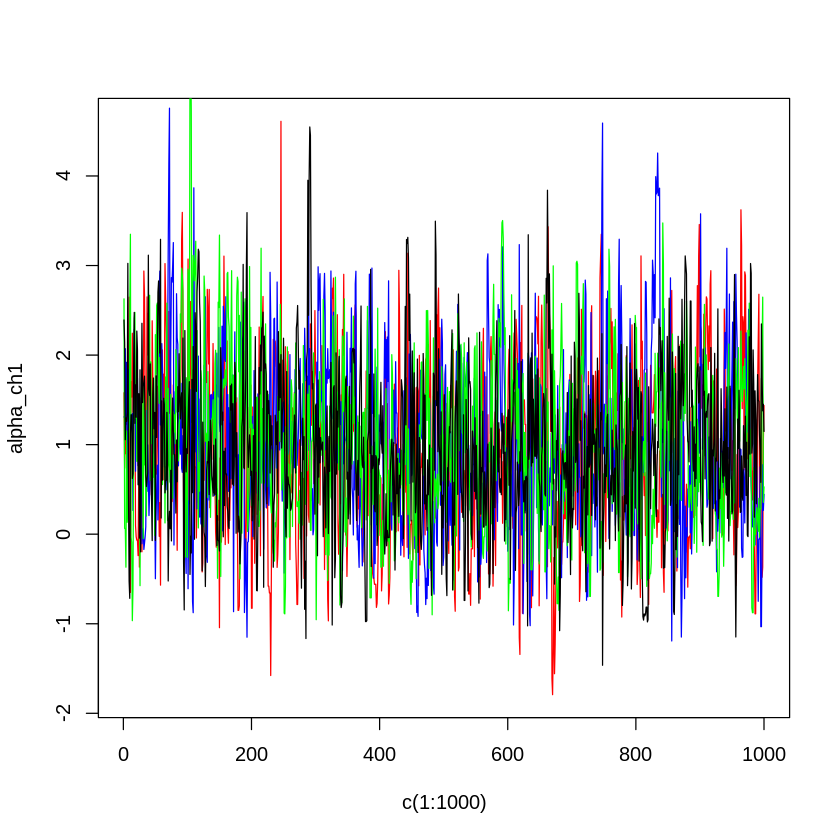

In [10]:
plot(c(1:1000),alpha_ch1, type = 'l', col = 'red'  )
lines(c(1:1000),alpha_ch2, type = 'l', col = 'blue' )
lines(c(1:1000),alpha_ch3, type = 'l', col = 'green')
lines(c(1:1000),alpha_ch4, type = 'l')

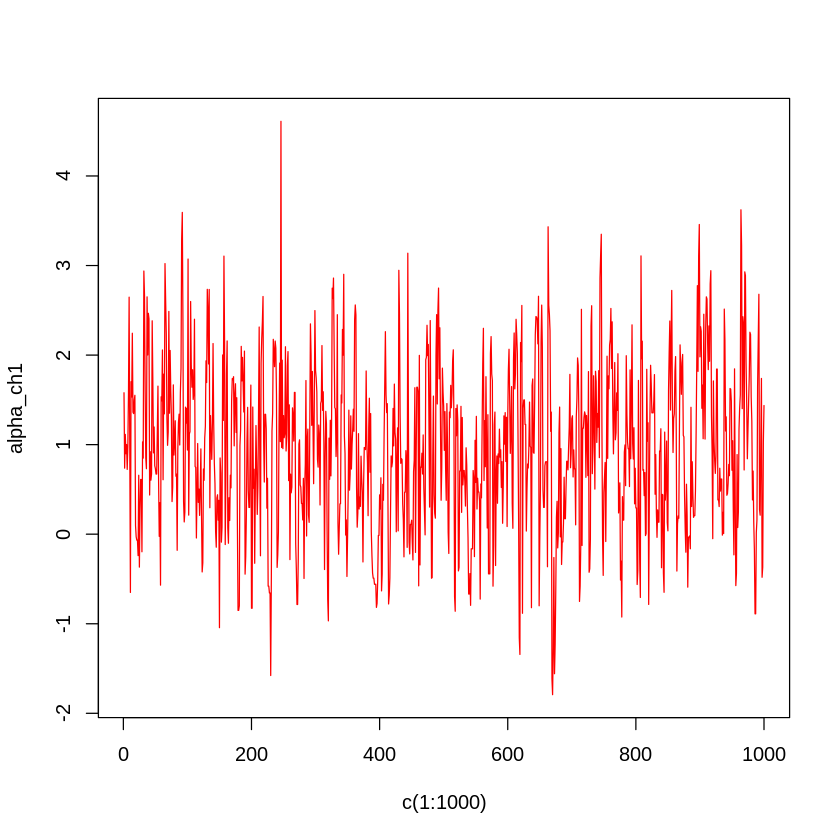

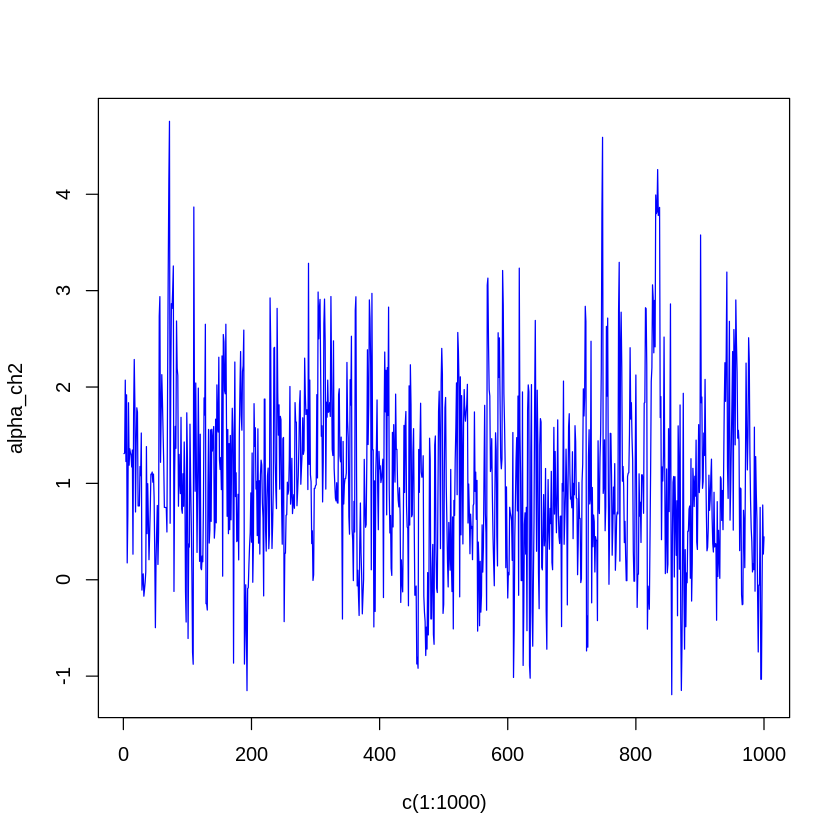

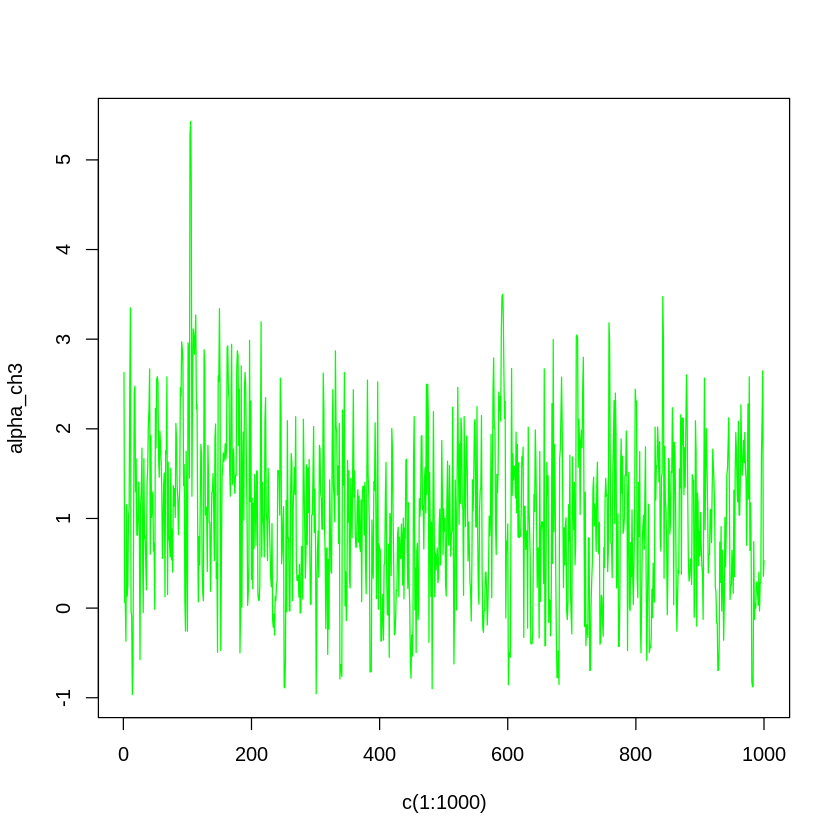

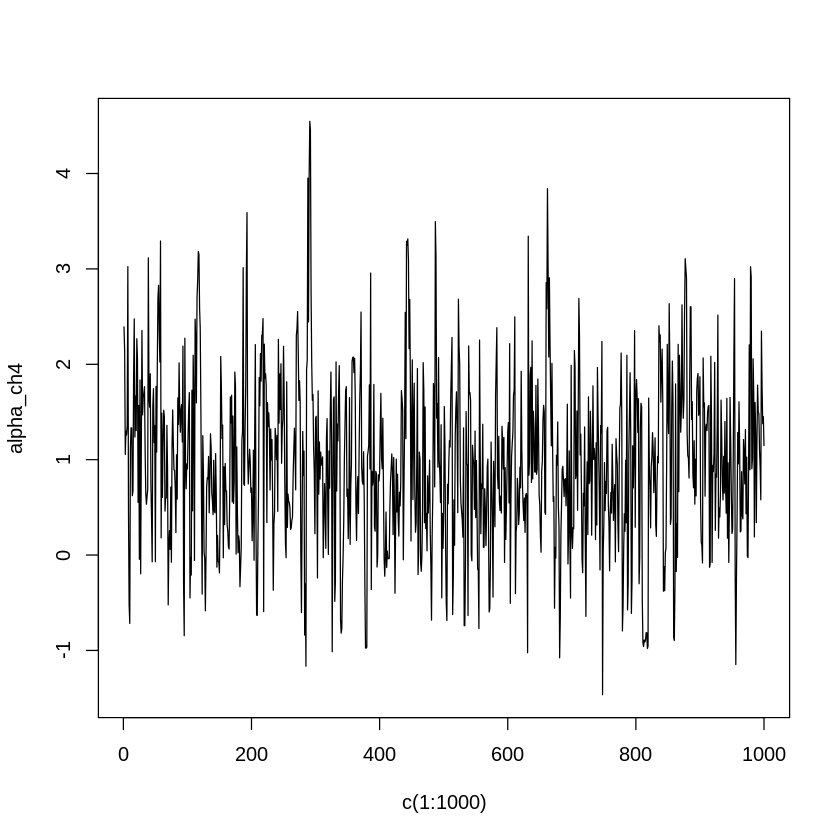

In [11]:
plot(c(1:1000),alpha_ch1, type = 'l', col = 'red'  )
plot(c(1:1000),alpha_ch2, type = 'l', col = 'blue' )
plot(c(1:1000),alpha_ch3, type = 'l', col = 'green')
plot(c(1:1000),alpha_ch4, type = 'l')

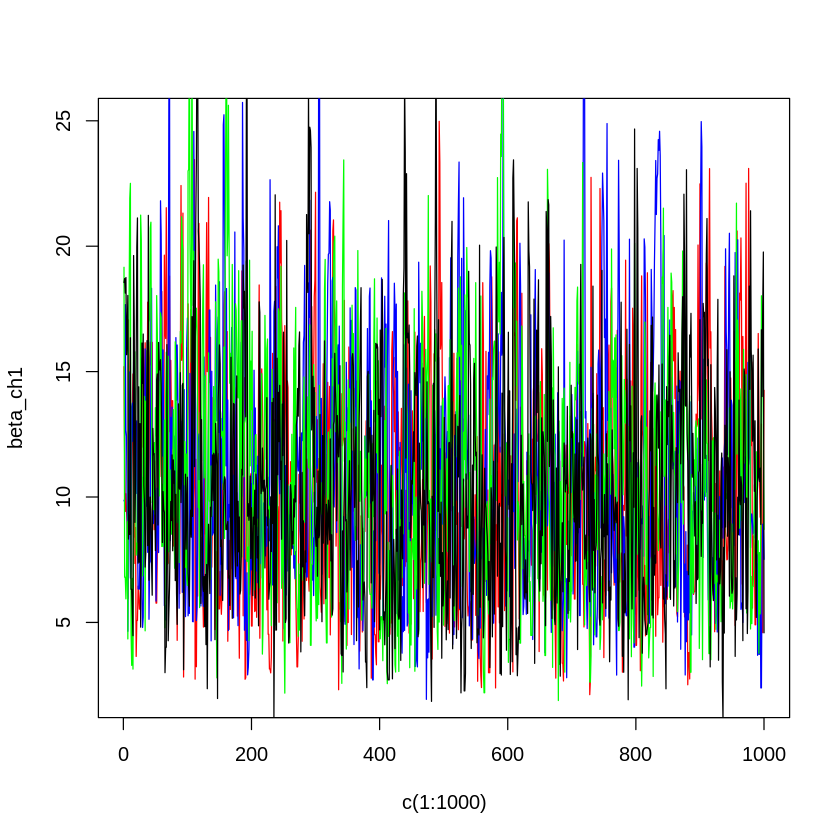

In [12]:
plot( c(1:1000), beta_ch1, type = 'l', col = 'red'  )
lines(c(1:1000), beta_ch2, type = 'l', col = 'blue' )
lines(c(1:1000), beta_ch3, type = 'l', col = 'green')
lines(c(1:1000), beta_ch4, type = 'l')

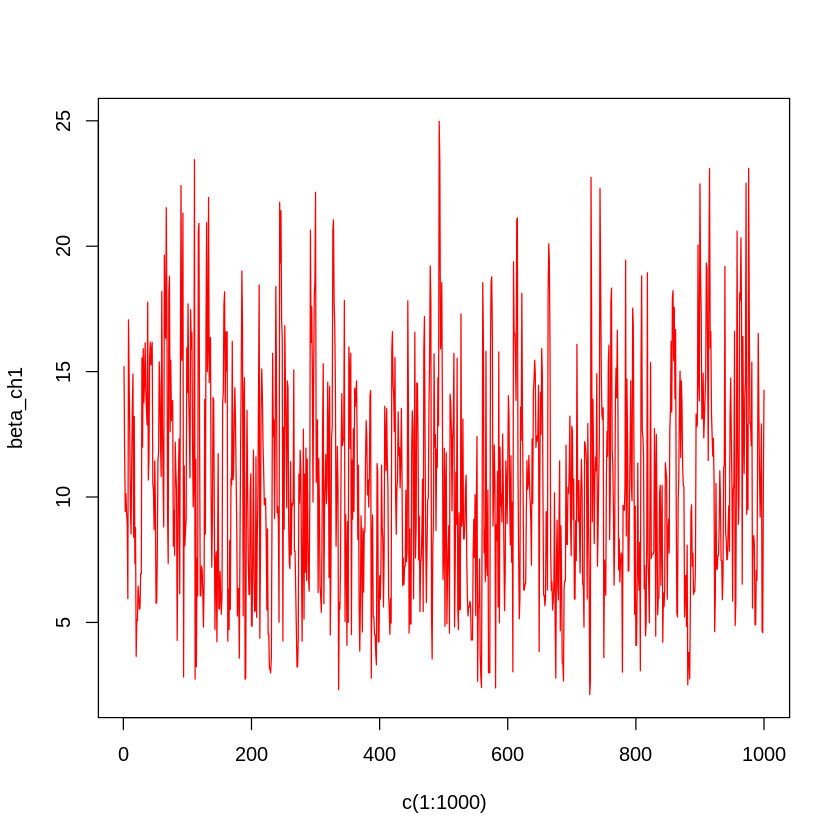

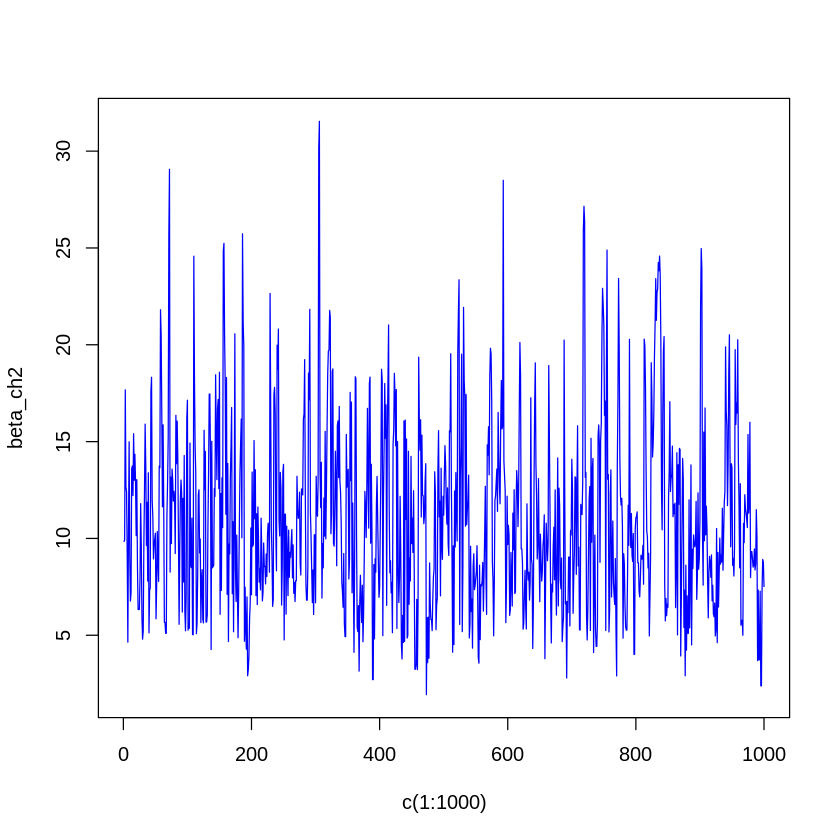

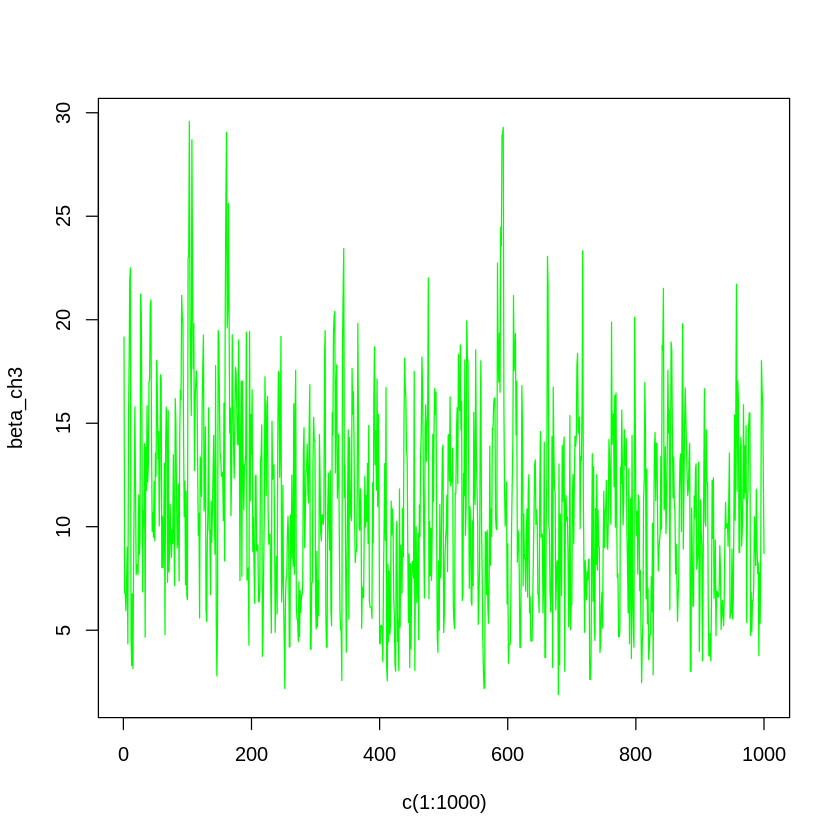

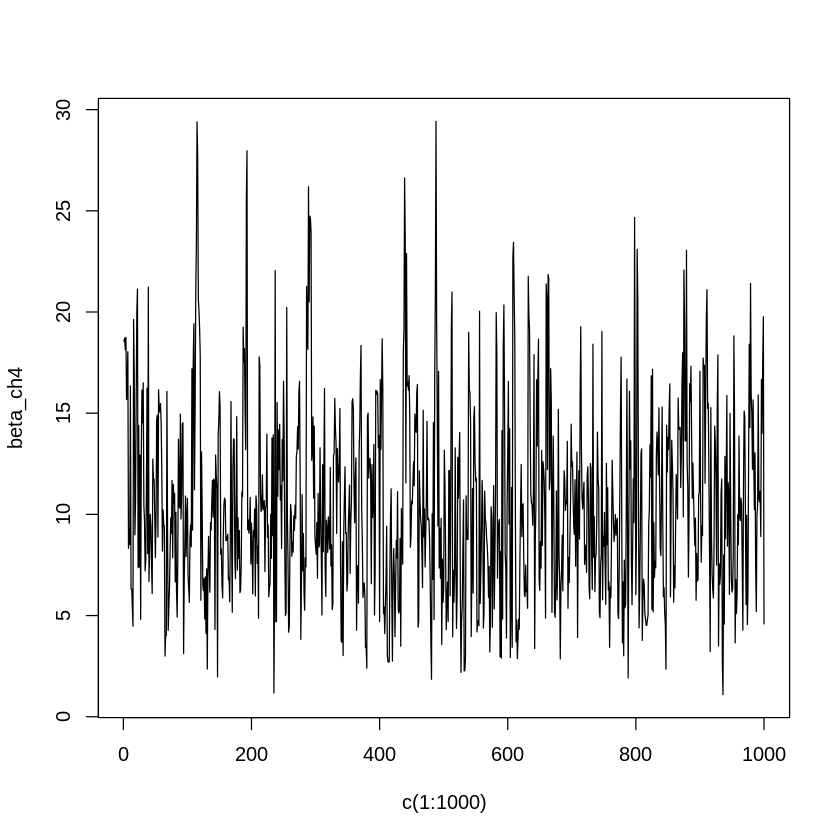

In [13]:
plot(c(1:1000),beta_ch1, type = 'l', col = 'red'  )
plot(c(1:1000),beta_ch2, type = 'l', col = 'blue' )
plot(c(1:1000),beta_ch3, type = 'l', col = 'green')
plot(c(1:1000),beta_ch4, type = 'l')

# Exercise 2)

In [14]:
## sumary
fit$summary()

variable,mean,median,sd,mad,q5,q95,rhat,ess_bulk,ess_tail
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
lp__,-7.1709683,-6.8575000,1.0508000,0.7887210,-9.1657845,-6.1717330,1.000660,1325.424,1615.700
alpha_beta[1],0.9945960,0.9552095,0.9222588,0.9081896,-0.4743281,2.5801000,1.001201,1114.859,1260.546
alpha_beta[2],10.7441560,10.1570500,4.6944619,4.7297016,4.2852760,19.3464050,1.002436,1068.530,1388.525
theta[1],-8.2453778,-7.7928450,3.5421193,3.4564224,-14.7554500,-3.2848255,1.002084,1300.458,1732.693
theta[2],-2.2286507,-2.1271500,1.1082418,1.0578796,-4.2557835,-0.6085568,1.000870,2638.062,2501.178
theta[3],0.4573882,0.4350320,0.7987656,0.7810515,-0.8207328,1.8171025,1.000683,1369.594,1765.133
theta[4],8.8378299,8.3675650,4.0622643,4.1399900,3.0163800,16.0967500,1.002491,980.797,1290.259


If we check both rhat from $\alpha$ and $\beta$ Rhat's are below the recommended values of $1.01$, which means that the chains have correctly explored the target distribution. This is the case not only for the posterior parameter means but from any quantity derived from expectations w.r.t this distribution. 

The way we interpret this Rhat values is as follows. Each chain is splitted into two subchains and both within and between variance is derived. The within variance underestimates the total variance because single chains might not have visited the whole posterior space. On the other hand the numerator in the Rhat can overestimate the total variance, if the chains are initialized from very overdispersed points. This is because overdispersed points are eventually out from the target distribution and thus for finite sample size the overall variance will be higher than that of the target distribution. Finally, the Rhat measures the deviation from this total variance w.r.t. the within chain variance. If the total variance of all the chains is greater than the within chain variance, this means that all the chains have not visited the whole distribution. Thus, the Rhat can be understood as the factor that can be reduced if we continue simulation, since in this case the within chain variance will approach the total variance.

# Exercise 3)

In [15]:
draws_df <- fit$draws( format = 'df' )

In [16]:
post_alpha <- draws_df$'alpha_beta[1]'
post_beta  <- draws_df$'alpha_beta[2]'

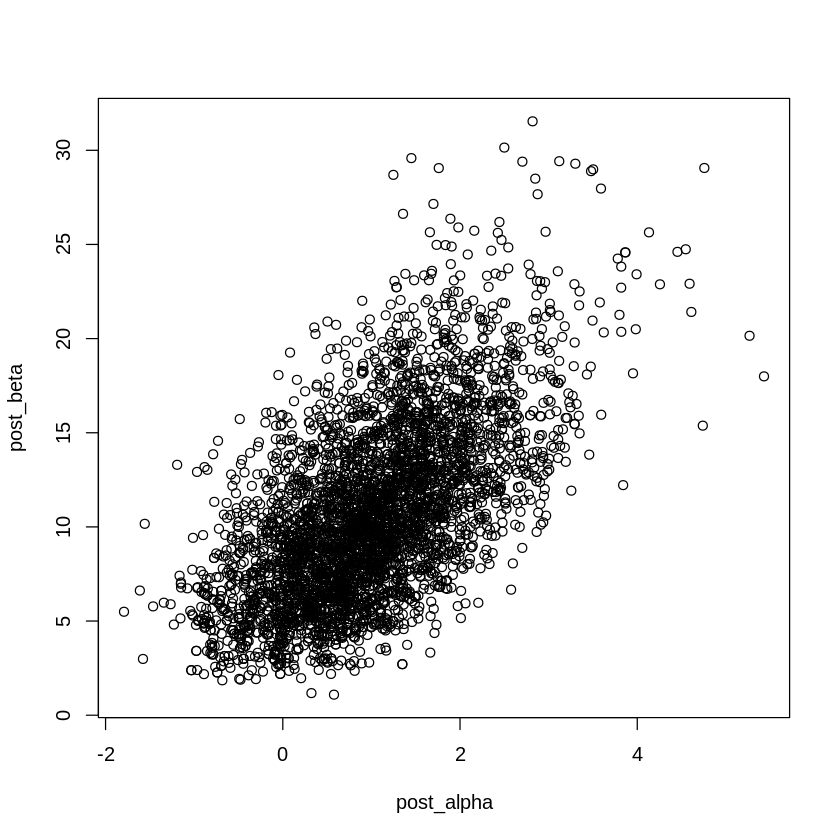

In [17]:
plot(post_alpha,post_beta)

# Exercise 4)

* who uses windows?
* R (although the first time I did something with stan was in python). However switched to R since it seems the community has more to say for MCMC stan.
* CmdstanR ( I tried Pystan and is bullshit and cmdstanpy was great).
* No. Set appropiate flags. Also compiled for GPU and openMPI
* Locally.
* Nothing (probably because I had a bit of experience already).

In [ ]:
library(markmyassignment)
assignment_path <-
paste("https://github.com/avehtari/BDA_course_Aalto/,
blob/master/assignments/tests/assignment6.yml", sep="")
set_assignment(assignment_path)
# To check your code/functions, just run
mark_my_assignment()